In [1]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_probability, plot_corner_emcee, plot_walker_emcee, \
     display_median_from_chain, log_likelihood, log_prior_global_uniform
import sys 
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
#import brightness and error for each Flare and TRAPPIST-1
flare1 = np.genfromtxt("../results/values/brightnesstot_flare1_TRAPPIST-1.txt",delimiter="," , skip_header=1)
flare2 = np.genfromtxt("../results/values/brightnesstot_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
trappist = np.genfromtxt("../results/values/brightness_TRAPPIST-1.txt", delimiter= ",", skip_header=1)
trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
trappistflux_M2 = np.genfromtxt("../results/values/brightness_TRAPPIST-1_withCCDeffeciency.txt", delimiter= ",", skip_header=1)

In [38]:
#import flare brightness and spectral energy dist. in M2
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappist_SED[:,1]
brightness_flares, brightnesserror_flares = np.reshape(np.concatenate((flare1[0],flare2[0])), (2,4)), \
                                            np.reshape(np.concatenate((flare1[1], flare2[1])), (2,4))
#flux/brighntess is in erg cm-2 -s

#Import M2 response, passband limits
iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [39]:
#Transfer to right units
brightness_flares = brightness_flares* u.erg *u.s**(-1) * u.cm**(-2)
brightnesserror_flares = brightnesserror_flares * u.erg *u.s**(-1) * u.cm**(-2)
brightness_flares = brightness_flares.to("W/m^2")
brightnesserror_flares = brightnesserror_flares.to("W/m^2")

brightness_flares = brightness_flares.to("W/m^2").value
brightnesserror_flares = brightnesserror_flares.to("W/m^2").value 

In [5]:
flux_SED = flux_SED * u.erg * u.s**(-1) *u.cm**(-2) * u.Angstrom**(-1)
flux_SED = flux_SED.to("W m^-3")
flux_SED = flux_SED.value

In [6]:
import scipy.constants as c 
def _brightness_mod(wavelength_tot, limit, T_flare, a, fluxdensity_tot, T_star, R_star, dist_star, model = "thick"):
    
    '''
    Modified brightness calculator for every passband. It summs the brightness in the given limits. 
    So for Muscat we get four summed points. The model uses an optical thick approach. 

    Parameters
    -------------
    wavelength_tot : 1-d array
        total wavelength array to be sliced into passband contributions by limit
    limit: mx2-array
        m is the number of passbands, 2 because two boarders 
    T_flare: float
        Flare temperature [K]
    a: float
        Fraction of Radius of the star asociate with flaring area. 
    fluxdensity_tot: 1-d array
        total fluxdensity of the star given [W/m^3] 
    Stellar Paramer 
    --------------
    T_star: float 
        Temperature of star [K]
    R_star: float
        Radius of star [m]
    dist_star
        distance of star [m]
        
    Return 
    ----------
    mx1 array
        Apparent brightness of flare in the passbands at Earth
    
    '''
    
    
    brightness = []
    for i in range(len(limit)):
        if i ==1: 
            continue
        else:
            wavelength = wavelength_tot[limit[i][0]:limit[i][1]]
            pre_factor = 1/(dist_star**2) * 2*c.h*c.c**2 /(wavelength**5) * np.pi
            flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)
            if model == "thick":
                #total star in given passband #das ist super klein, deswegen hat es kaum einen Einfluss
                star_contribution = -(a)**2 * np.trapz(fluxdensity_tot[limit[i][0]:limit[i][1]])    #R_star/dist_star weg #es macht Sinn nur den faktro a da zu haben, wegen l = sum flux l_a = a sum flux
            else: 
                #thin case, a sign
                star_contribution = (a)**2 * np.trapz(fluxdensity_tot[limit[i][0]:limit[i][1]])  
            brightness.append(np.nansum(pre_factor * (flare_contribution))  + star_contribution) 
        
    return np.asarray(brightness)

In [7]:
def log_likelihood(theta, x, y, yerr, limit, fluxdensity_star, T_star, R_star, dist_star):
    T, a, = theta
    model = _brightness_mod(x, limit, T, a , fluxdensity_star, T_star, R_star, dist_star) 
    y = np.asarray([y[0], y[2], y[3]])
    yerr = np.asarray([yerr[0], yerr[2], yerr[3]])
    return -0.5 * (np.sum(((y - model)/yerr) ** 2 ))

In [8]:
from scipy.optimize import minimize

#Define parameters of the TRAPPIST-1
parameters_op = []
t_star = 2648 #[K] #Wilson et al 2021 
r_star = 0.1192 * ca.R_sun.value #
dist_star = dist_TRAP = 3.835084e+17 #[m]

#initial values for MCMC
for i in range(len(brightness_flares)):
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([5000,0.1] + 0.01 * np.random.randn(2))
    soln = minimize(nll, initial, args=(wavelength_SED, brightness_flares[i], \
                                        brightnesserror_flares[i], limit, flux_SED, \
                                        t_star, r_star, dist_star))
    T_op, a_op = soln.x 
    
    #ensure Temperature is not too high/low
    if T_op > 25000 or T_op < 3000:
        T_op = 6000 
        
    #ensure fraction of area is not negative 
    if a_op < 0:
        a_op = 1e-6
    
    parameters_op.append([T_op, a_op])

parameters_op = np.asarray(parameters_op)

In [9]:
parameters_op

array([[8.05363572e+03, 2.64445120e-01],
       [6.22992715e+03, 1.61132914e-01]])

In [10]:
import emcee
import corner
import matplotlib.pyplot as plt


n = 25000 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = parameters_op[i] + 1e-7 * np.random.randn(nwalkers, ndim)
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_prior_global_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=1500, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

  0%|                                        | 10/25000 [00:00<04:25, 94.25it/s]

Flare #1

  0%|                                        | 10/25000 [00:00<04:22, 95.10it/s]

Flare #2

100%|█████████████████████████████████████| 25000/25000 [04:28<00:00, 92.98it/s]


In [11]:
#Write chain data to arrays 

np.save("../data/MCMC/samples_norfilter_total", samples_total, allow_pickle=True, fix_imports=True)
np.save("../data/MCMC/samplesflat_norfilter_total", samplesflat_total, allow_pickle=True, fix_imports=True)

In [8]:
#Load data from chain 

samples_total = np.load("../data/MCMC/samples_norfilter_total.npy")
samplesflat_total = np.load("../data/MCMC/samplesflat_norfilter_total.npy")

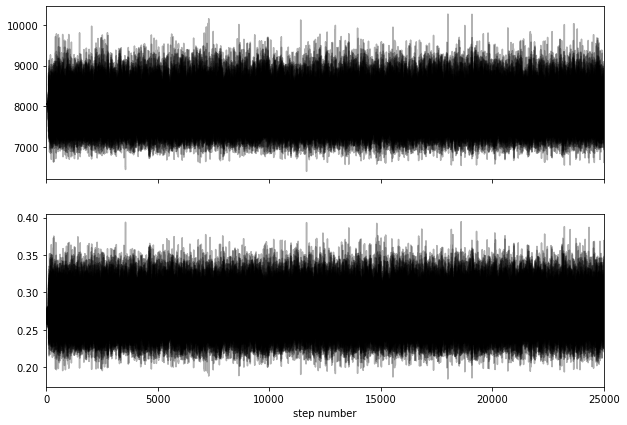

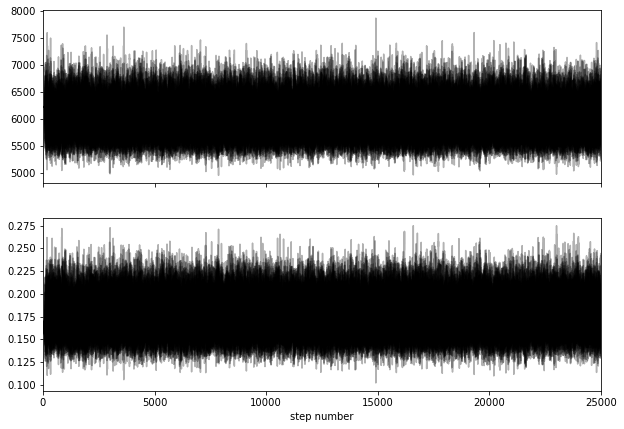

In [12]:
%matplotlib inline
plot_walker_emcee(samples_total)

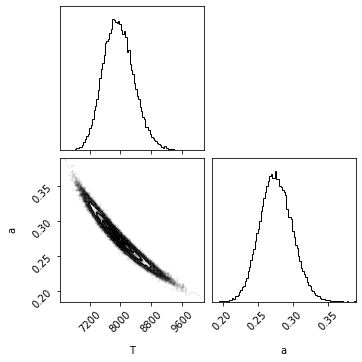

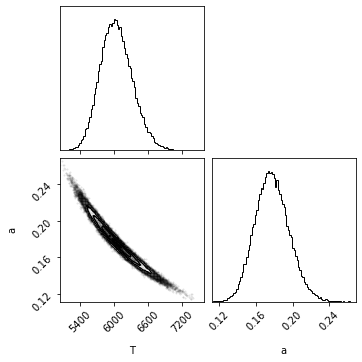

In [13]:
plot_corner_emcee(samplesflat_total)

In [14]:
results = display_median_from_chain(samplesflat_total) ##implement mode, mean 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
T_med = results[0][0]
a_med = results[2][0]


T_high = results[0][0] + results[1][0][1]
T_low = results[0][0] - results[1][0][0]
a_high = results[2][0] + results[3][0][0]
a_low = results[2][0] - results[3][0][0]


In [20]:
T_med2 = results[0][1]
a_med2 = results[2][1]


T_high2 = results[0][1] + results[1][1][1]
T_low2 = results[0][1] - results[1][1][0]
a_high2 = results[2][1] + results[3][1][0]
a_low2 = results[2][1] - results[3][1][0]

In [41]:
#Changes to three filters

limitss = np.asarray([limit[0][1] - limit[0][0], limit[1][1] - limit[1][0] , limit[2][1] - limit[2][0], \
                      limit[3][1] - limit[3][0]]) 
brightness_flares_1 = np.asarray([brightness_flares[0,0],brightness_flares[0,2],brightness_flares[0,3]])
brightness_flares_2 = np.asarray([brightness_flares[1,0],brightness_flares[1,2],brightness_flares[1,3]])

brightnesserror_flares_1 = np.asarray([brightnesserror_flares[0,0],brightnesserror_flares[0,2],brightnesserror_flares[0,3]])
brightnesserror_flares_2 = np.asarray([brightnesserror_flares[1,0],brightnesserror_flares[1,2],brightnesserror_flares[1,3]])

limitss = np.asarray([limitss[0], limitss[2], limitss[3]])

wavelength_M2 = np.asanyarray([wavelength_M2[0], wavelength_M2[2], wavelength_M2[3]]) 

In [46]:
wavelength = wavelength_SED[1000:14000]
flux = flux_SED[1000:14000]

inds = np.random.randint(len(samplesflat_total[0]), size=100) #
import warnings
warnings.filterwarnings("ignore")

temperatures_flare1 = np.zeros([100,len(wavelength)])
temperatures_flare2 = np.zeros([100,len(wavelength)])
i=0
for ind in inds:
    sample = samplesflat_total[0][ind]
    temperatures_flare1[i] = 1e6*brightness_mod_continous(wavelength,sample[0],sample[1], \
                                          flux,t_star,r_star, dist_star, model = None)
    i = i+1

i=0
for ind in inds:
    sample = samplesflat_total[1][ind]
    temperatures_flare2[i] = 1e6*brightness_mod_continous(wavelength,sample[0],sample[1], \
                                          flux,t_star,r_star, dist_star, model = None)
    i = i+1
    

In [37]:
brightness_flares, temperatures_flare1[0]

(array([[1.78278284, 1.31296951, 0.6709689 , 0.26597228],
        [0.21538092, 0.20120356, 0.10757245, 0.02085279]]),
 array([1.48878010e-09, 1.50858464e-09, 1.52860497e-09, ...,
        9.21592342e-08, 9.21381513e-08, 9.21170745e-08]))

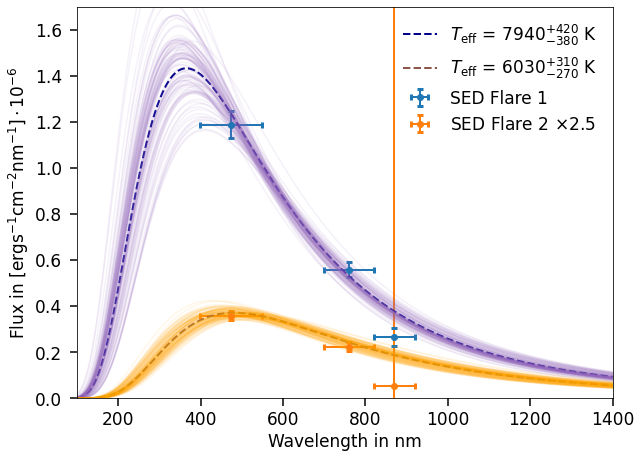

In [50]:
#need to change units at the moment W/m^2


lc = [4.745e-07, 6.245e-07, 7.6e-07, 8.695000000000001e-07]
ranges = np.asarray([1.4999999999999994e-07, 1.1900000000000005e-07, 1e-07])/2*1e9
#sum of datapoints in wavelength array for continous model


import matplotlib.pyplot as plt
from matplotlib import rcParams  #ticks for axes
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams["figure.figsize"] = [9.6, 7.2] 
rcParams.update({'font.size': 17})

#plt.figure(figsize=(12,9.6))
plt.rcParams['font.size'] = '17'


plt.errorbar(np.asarray(wavelength_M2)*1e9,brightness_flares_1*1e6/limitss, xerr = ranges, yerr = brightnesserror_flares_1*1e6/limitss ,fmt=".", color = "tab:blue", \
                        ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = "SED Flare 1")

plt.plot(wavelength_SED*1e9,  \
         1e6*brightness_mod_continous(wavelength_SED, T_med, a_med, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $7940^{+420}_{-380}$ K", linewidth = 2, color = "darkblue") #, array([5127.88550742]


for i in range(100):
    plt.plot(wavelength_SED[1000:14000]*1e9,temperatures_flare1[i], color = "tab:purple", alpha = 0.09)  
        


plt.xlim(100,1000)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-12}$")



plt.errorbar(np.asarray(wavelength_M2)*1e9,1e6*2.5*brightness_flares_2/limitss, xerr = ranges, yerr = 2.5*1e6*brightnesserror_flares_2/limitss ,color="tab:orange", \
                         ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = r"SED Flare 2 $\times 2.5$")

plt.plot(wavelength_SED*1e9,  \
         2.5*1e6*brightness_mod_continous(wavelength_SED, T_med2, a_med2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $6030^{+310}_{-270}$ K", linewidth = 2, color = "tab:brown") #, array([5127.88550742]


for i in range(100):
    plt.plot(wavelength_SED[1000:14000]*1e9,2.5*temperatures_flare2[i], color = "orange", alpha = 0.09)  
        

plt.xlim(100,1400)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-6}$") #W/^3 --> erg/cm^2/s^1/nm
plt.ylim(0,1.7) 

plt.legend(loc = "upper right",frameon = False) 

plt.savefig("../results/plots/SED_no_rfilter.png")